# What Makes a Great Wine? Using Linear Regression to Study Which Variables Influence Wine Quality

This file contains all code and analysis of results pertaining to using linear regression to study which variables influence wine quality. Specifically, we are here looking at red and white variants of the Portuguese 'Vinho Verde' wine. As mentioned in the README file, I here use public data from Kaggle (https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009).

## Relevant Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import RobustScaler

# Data Cleaning

In [2]:
data = pd.read_csv("winequality-red.csv")
data

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


A quick check to see whether the data was cleaned shows that while there are no NaN values, there are 240 duplicate rows. I therefor first check what they look like, and thereafter drop them from my dataset

In [3]:
print("Duplicate rows:", data.duplicated().sum())
print("NaN values per column:\n", data.isna().sum())

Duplicate rows: 240
NaN values per column:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [4]:
duplicates_all = data[data.duplicated(keep=False)]
duplicates_all

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
9,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
11,7.5,0.500,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
22,7.9,0.430,0.21,1.6,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1567,7.2,0.695,0.13,2.0,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1579,6.2,0.560,0.09,1.7,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5
1581,6.2,0.560,0.09,1.7,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5
1592,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6


In [5]:
data = data.drop_duplicates()

In [6]:
print(f"there are {data.index.size} rows in the dataset")

there are 1359 rows in the dataset


# Exploratory Data Analysis

Next, I gather more information about the dataset ot build an overview. For example, and quite interestingly so, the key variable of interest here - quality of wine - shows a mean value (M = 5.62, SD = 0.83) that is quite in the middle of the range of possible values. However, since the source of the dataset does not indicate *how the items of the question were*, it is impossible to know the exact range of the wine. However, one can perhaps presume, based on the low spread of quality indications, that there are mostly mediocre wines as opposed to poor or excellent wines.

In [7]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,8.310596,0.529478,0.272333,2.523400,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315,5.623252
std,1.736990,0.183031,0.195537,1.352314,0.049377,10.447270,33.408946,0.001869,0.155036,0.170667,1.082065,0.823578
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996700,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997820,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [8]:
data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

As can also be seen below, there seems to be a large variety in distributions. For the planned analysis - a linear regression - it however only matter that there is a constant variance of error terms across these distributions, as will be checked for later. However, we can witness a large degree of outliers in certain cases - these we will have to remove later to fit the test.

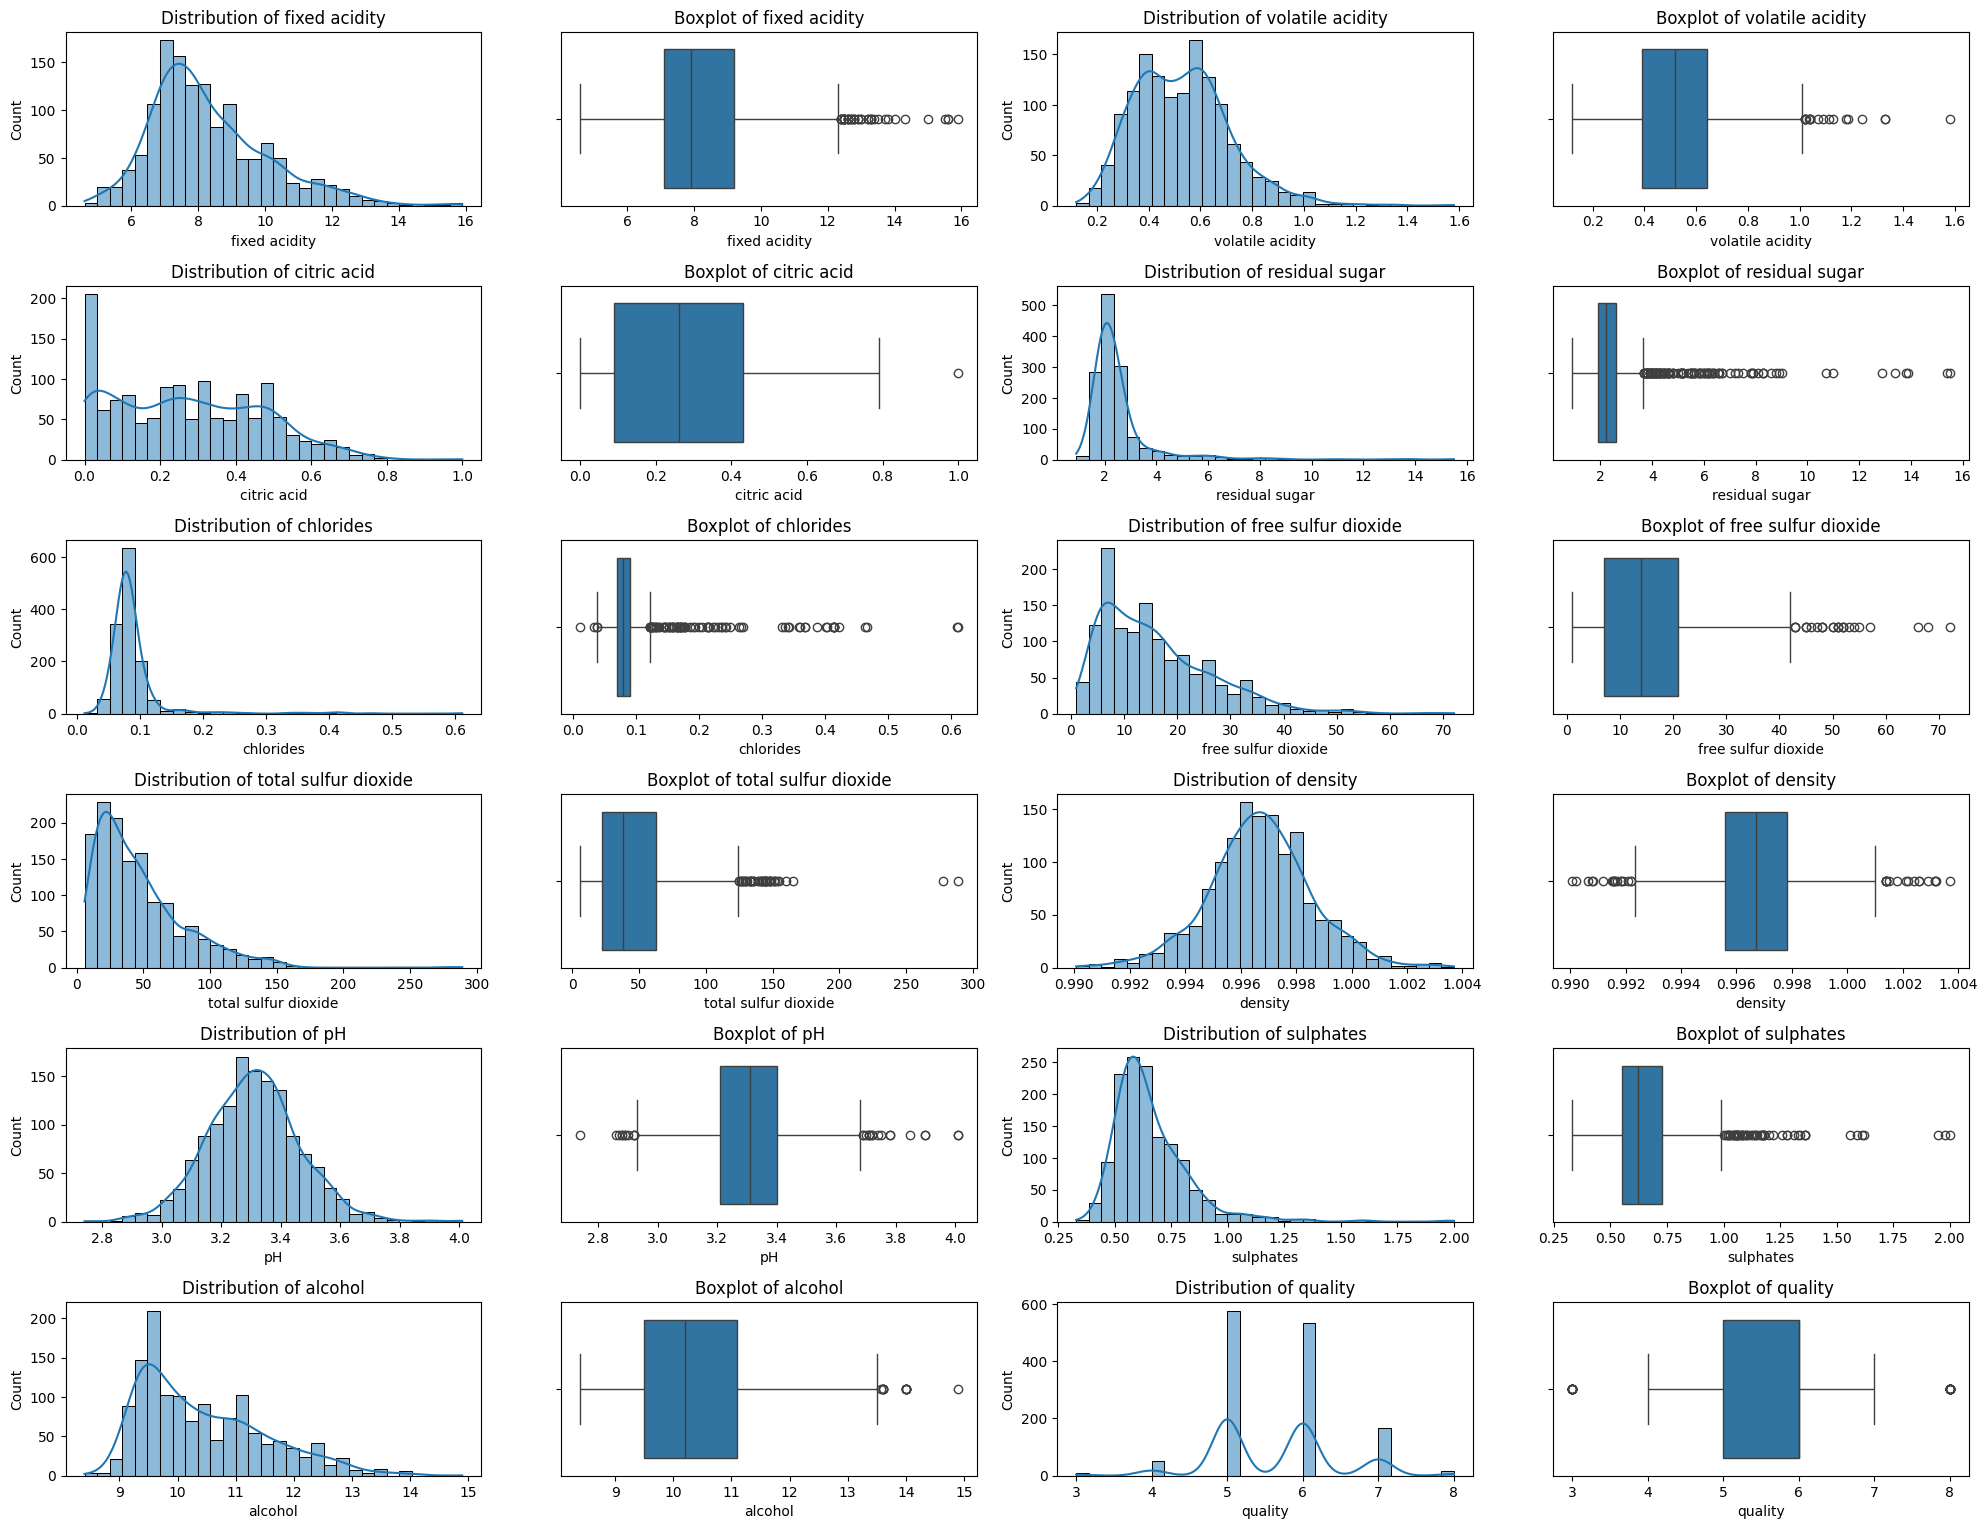

In [9]:
features = data.columns
n_cols = 4
n_rows = int(len(features) * 2 / n_cols) + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2.5))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(data[col], kde=True, bins=30, ax=axes[2 * i])
    axes[2 * i].set_title(f"Distribution of {col}")

    sns.boxplot(x=data[col], ax=axes[2 * i + 1])
    axes[2 * i + 1].set_title(f"Boxplot of {col}")

for j in range(2 * len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Next I quickly plot each independent variable of wine here (e.g., pH, sulphates, chlorides, etc.) on quality through boxplots - just to get another sense of what the data looks like. As can be seen there are a large amount of variance, and a few variables, at least ostensibly, indicate patterns on quality, such as volatine acidity. However, there also seems to be a good degree of outliers. While the removal of outliers later might remediate this, the possibility of them persisting would indicate a degree of high leverage points, which would further weaken our model (as this might violate another assumption). Regardless, I will later perform a Cook's Distance test to check this.

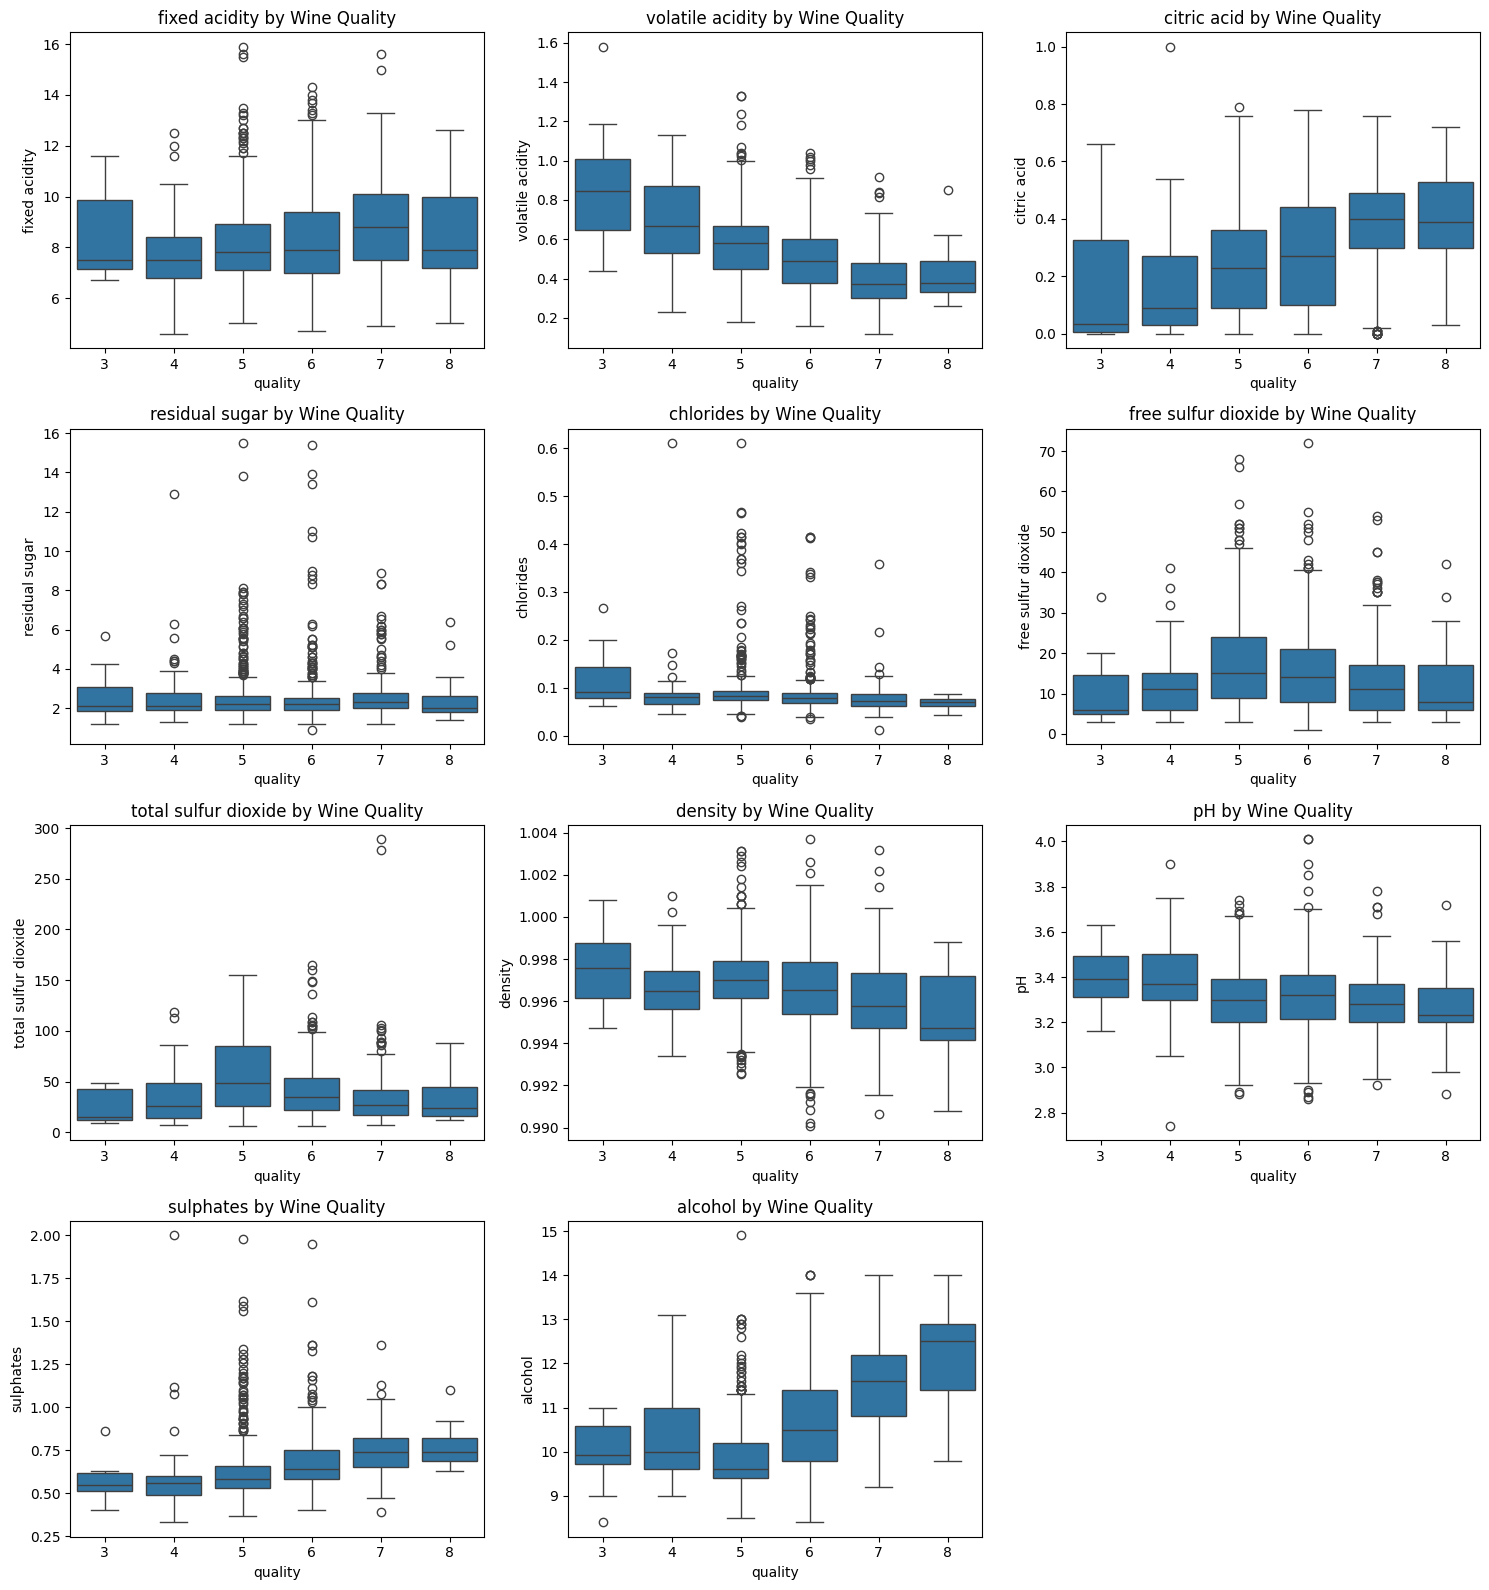

In [10]:
features = data.columns.drop("quality")

n_cols = 3
n_rows = (len(features) // n_cols) + int(len(features) % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(x="quality", y=col, data=data, ax=axes[i])
    axes[i].set_title(f"{col} by Wine Quality")

for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Scaling the Data
Next I use RobustScaler to scale the data to make it more comparable and less likely to skew the results.
I use RobustScaler because it handles outliers well - and because this dataset does not have a lot of values at the ends, it would be beneficial to not end up removing some of these. Also, the distributions of the data all vary, and so StandardScaler would not work well if used across the board (since it does not work well on data that doesn't follow a Gaussian distribution).

In [11]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
            'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

scaler = RobustScaler()

df = data.copy()

df[features] = scaler.fit_transform(data[features])

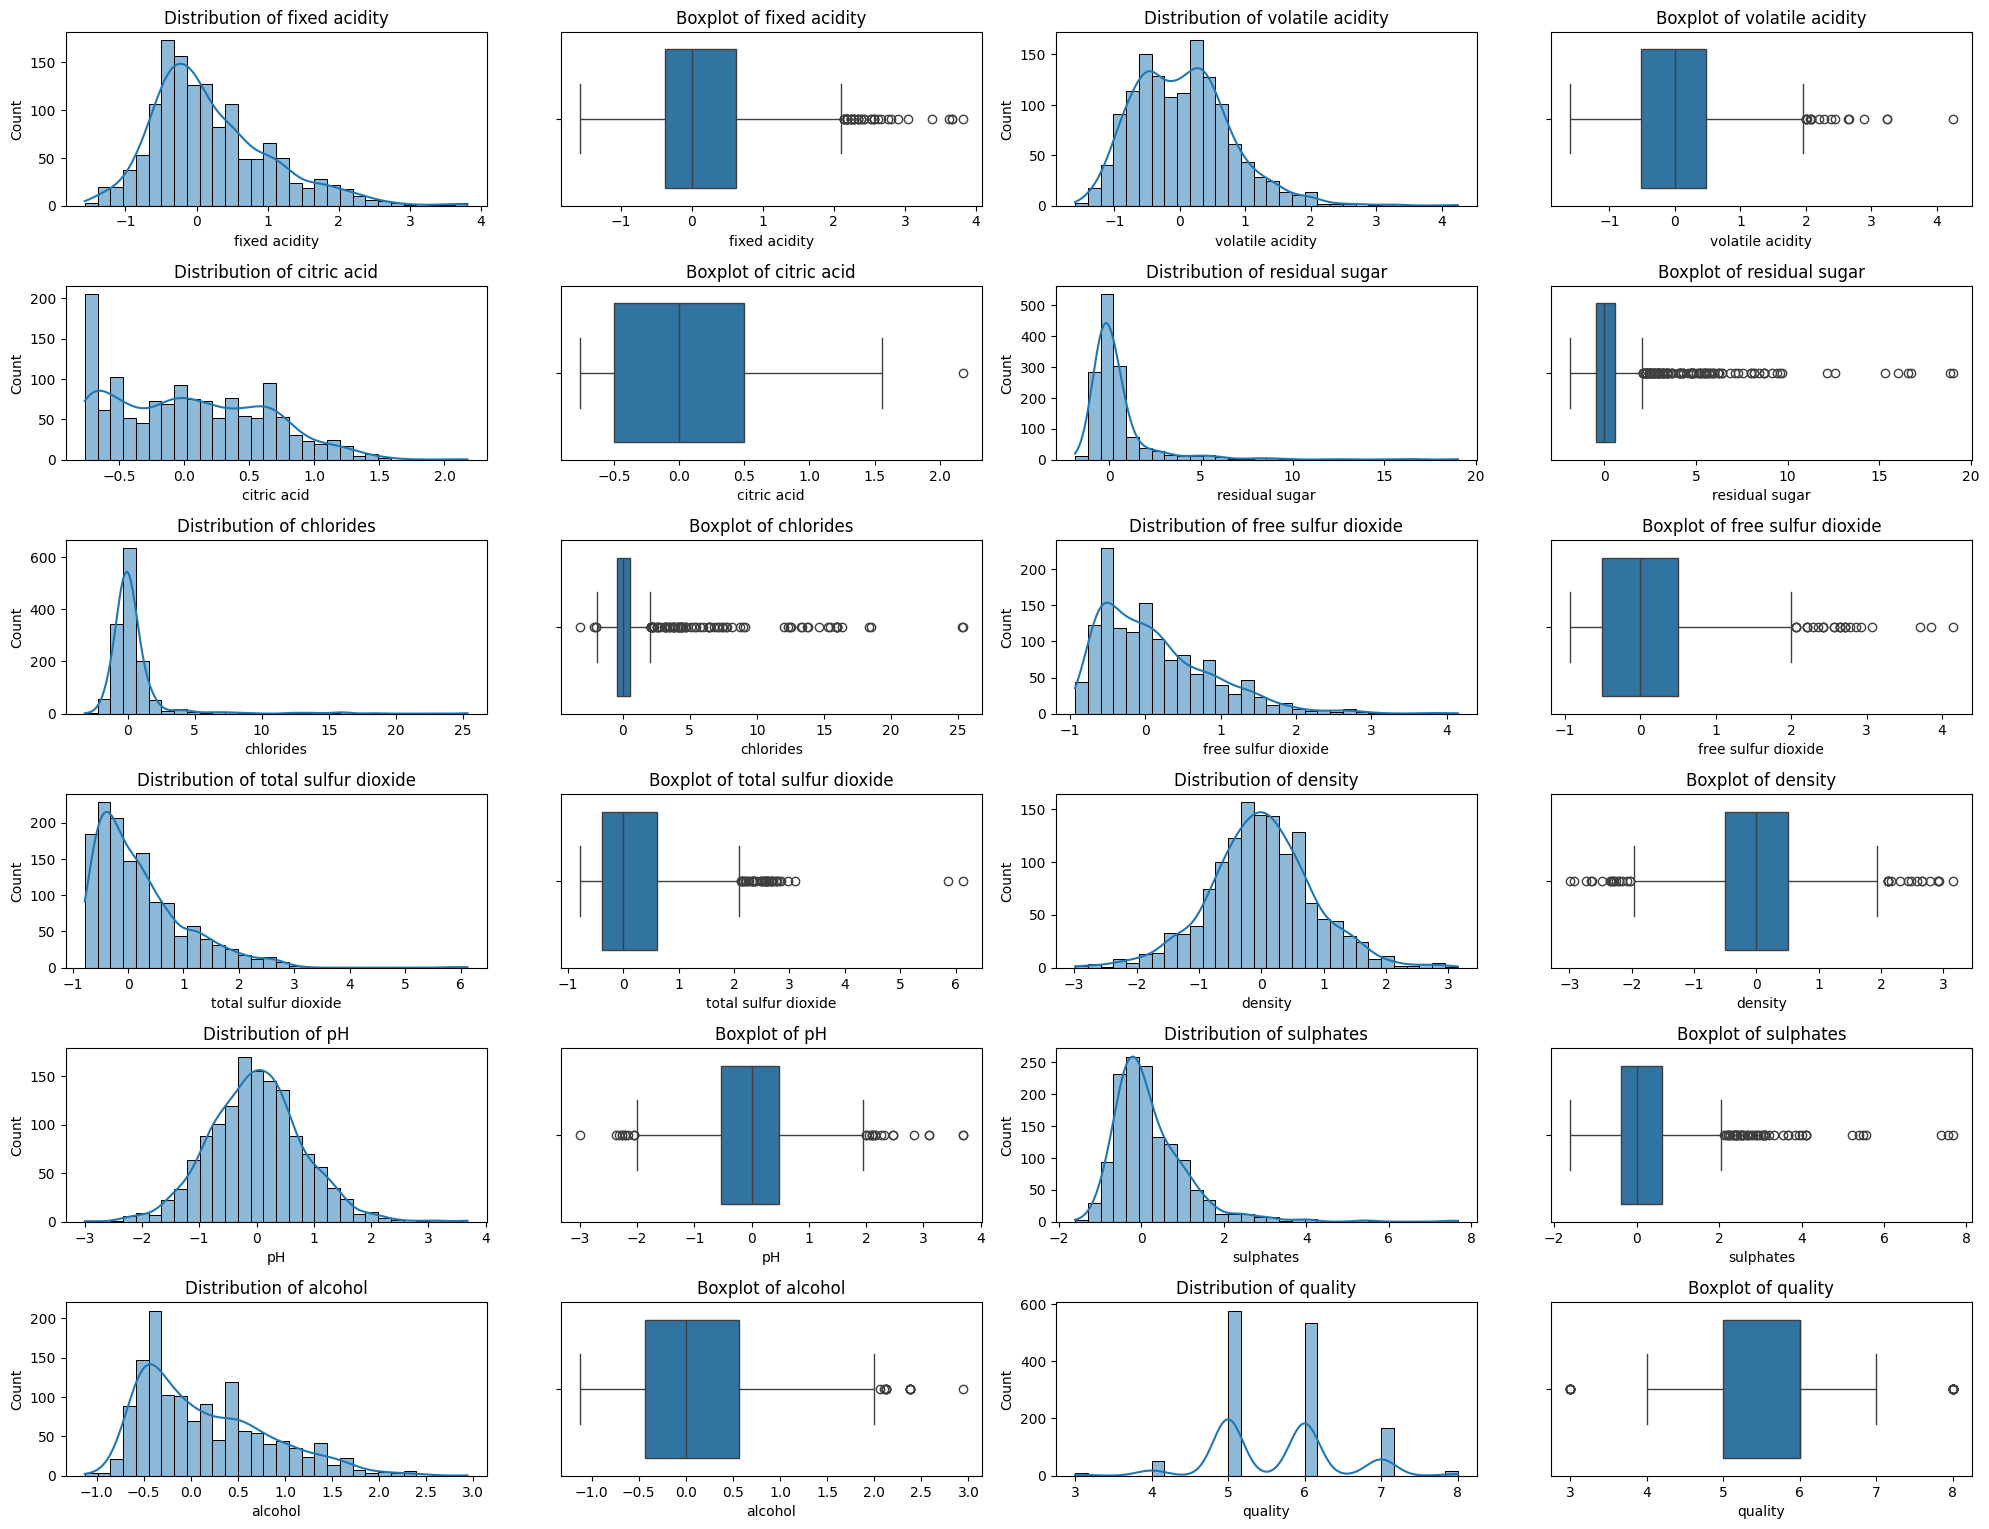

In [12]:
features = df.columns
n_cols = 4
n_rows = int(len(features) * 2 / n_cols) + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 2.5))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(df[col], kde=True, bins=30, ax=axes[2 * i])
    axes[2 * i].set_title(f"Distribution of {col}")

    sns.boxplot(x=df[col], ax=axes[2 * i + 1])
    axes[2 * i + 1].set_title(f"Boxplot of {col}")

for j in range(2 * len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Checking for Multicollinearity

Next I create a heat map to see if any different variables are highly correlated. As can be seen, there are a variety of different variables that are notably correlated. This could pose a potential issue, as it can inflate beta coefficients and make it hard to tell which variable is actually influencing our dependent variable of wine quality.

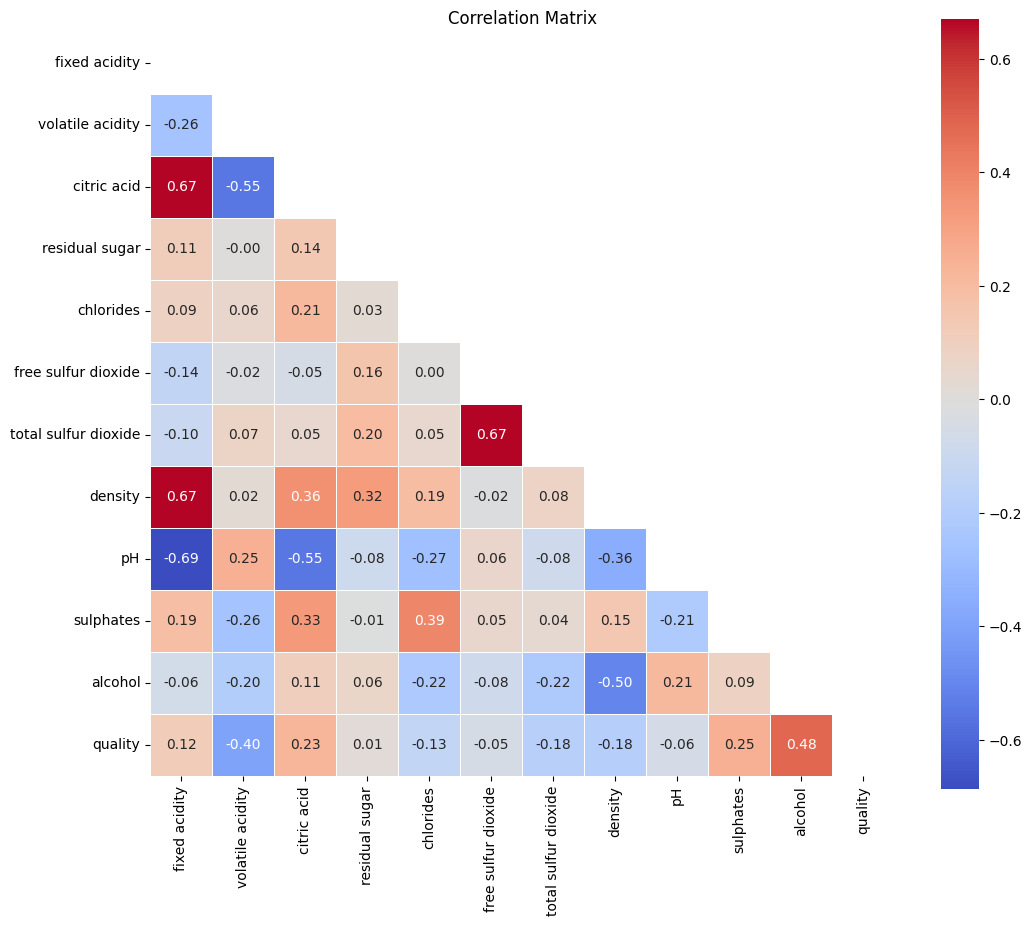

In [13]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", square=True, linewidths=0.5
)
plt.title("Correlation Matrix")
plt.show()

## Using VIF to Kick Out the Multicollinearity
Because I do plan to run a linear regression, multicollinearity needs to be removed prior to this. To do this, we use VIF. With values between 5 and 10 showing moderate multicollinearity, we see that two variables, namely fixed acidity (7.881) and density (6.281) exist within this range. Positively, the rest are quite low, with none passing the level of 10, which is often understood as truly problematic. 

When researching more about wine, I found out that density is mostly a compound function of sugar and alcohol content (https://williamsminneapolis.com/density-of-wine-vs-water/#:~:text=The%20density%20of%20wine%20is,lower%20mass%20compared%20to%20water.), which we already study individually in this dataset. Consequently, I decide to drop density, and rerun VIF to see how it now turns out.

As we can see below, fixed acidity now only has a VIF of 2.988, which is acceptable for the analysis.

In [14]:
X = df.drop(columns=["quality"])

X_with_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(X_with_const.shape[1])
]

print(vif_data)

                Variable       VIF
0                  const  1.735182
1          fixed acidity  7.880951
2       volatile acidity  1.777884
3            citric acid  3.124679
4         residual sugar  1.641987
5              chlorides  1.530769
6    free sulfur dioxide  1.950922
7   total sulfur dioxide  2.216688
8                density  6.281009
9                     pH  3.397407
10             sulphates  1.466779
11               alcohol  3.140944


In [15]:
X = df.drop(columns=["quality", "density"])

X_with_const = add_constant(X)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_with_const.values, i)
    for i in range(X_with_const.shape[1])
]

print(vif_data)

                Variable       VIF
0                  const  1.481031
1          fixed acidity  2.987597
2       volatile acidity  1.756197
3            citric acid  3.124085
4         residual sugar  1.096732
5              chlorides  1.513716
6    free sulfur dioxide  1.938953
7   total sulfur dioxide  2.203957
8                     pH  2.313263
9              sulphates  1.378823
10               alcohol  1.321842


In [16]:
df = df.drop(columns=["density"])

# Running a Linear Regression 

Next, I want to study whether there are actually any significant effects of the various variables here on wine quality. To reiterate, these variables include:

- Sulphates
- Alcohol level
- Total sulfur dioxide
- Density
- pH
- Free sulfur dioxide
- chlorides
- residual sugar
- citric acid
- volatile acidity
- fixed acidity

In doing this, I choose to run a linear regression for significance testing and prediction, as it fits this task well and is generally an industry-standard and useful model. To do this, I need to check the assumptions of this model, which are as follows:

- No outliers
- Generally linear data
- Non-correlation of error terms
- Constant variance of error terms (homoscedasticity)
- No high-leverage points
- No multicollinearity.

However, as several of these assumptions can only be checked after running the regression, I first run the regression, as shown below. However, before doing so, I also separate a random 20% of the data as a hold-out, so that I can later check the extrapolation value of the modelling (i.e., too see how high the variance between datasets is).

Note that in running this model, I also choose to focus on *explanatory power* as opposed to *predictive power*. This means that I will place a large emphasis on p-values, pay close attention to model assumptions, remove variables that violate multicollinearity (as it reduces the validity of others), and thereby also focus on model simplicity and interpretability as opposed to predictive power. This might run me closer to underfitting as opposed to overfitting, but this is fine given the goal.

In [17]:
X = df.drop(columns=["quality"])
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

While it is difficult to create hypotheses for this data, since we have no preexisting theory to back this up, I will make one hypothesis:

- H0: There *is no* significant effect of alcohol content on perceived wine quality
- H1: There *is a* significant negative effect of alcohol content on perceived wine quality. In other words, as alcohol content increases, the perceived wine quality will be lower.

As can be seen below, five variables are indicated to have a significant effect on wine quality. 

Firstly, the level of volatile acidity is a significant *negative* predictor of wine quality (p < 0.001, β = -0.2464), indicating that as the scaled value of volatile acidity increase by one IQR, wine quality *decreases* by approximately 0.2464, ceteris paribus. 

Secondly, the level of chlorides is a significant *negative* predictor of wine quality (p < 0.001, β = -0.0455), indicating that as the scaled value of chlorides increase by one IQR, wine quality *decreases* by approximately 0.0455, ceteris paribus. 

Thirdly, the level of total sulfur dioxide is a significant *negative* predictor of wine quality (p < 0.001, β = -0.1499), indicating that as the scaled value of total sulfur dioxide increase by one IQR, wine quality *decreases* by approximately 0.1499, ceteris paribus. 

Fourthly, the level of sulphates is a significant *positive* predictor of wine quality (p < 0.001, β = 0.1588), indicating that as the scaled value of total sulfur dioxide increase by one IQR, wine quality *increases* by approximately 0.1588, ceteris paribus. 

Fifthly, the level of alcohol is a significant *positive* predictor of wine quality (p < 0.001, β = 0.4568), indicating that as the scaled value of total sulfur dioxide increase by one IQR, wine quality *increases* by approximately 0.4568, ceteris paribus. 

This last measure thereby indicates that my hypothesis is incorrect.

Moreover, the model here indicates that this share of variables accounts for roughly 35.2% of the variance in wine quality (34.6% if using the adjusted R^2), which is quite a high number.

When we test this model against the 20% we withheld, we see that we firstly obtain an RMSE of 0.6537, which means that our models predictions of quality are on average off by 0.6394, which is a moderate error rate. Furthermore, we witness an R^2 of 0.3968, which is noticeably higher than it was for our model itself. This could be pure chance based on how the data was split, or it could indicate that the model simply performs well across datasets.

In [18]:
X_train_const = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     58.34
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           3.33e-94
Time:                        18:07:47   Log-Likelihood:                -1088.7
No. Observations:                1087   AIC:                             2199.
Df Residuals:                    1076   BIC:                             2254.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.5915 

In [19]:
X_test_const = sm.add_constant(X_test)

y_pred = model.predict(X_test_const)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print(f"Test RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")

Test RMSE: 0.6537
Test R-squared: 0.3968


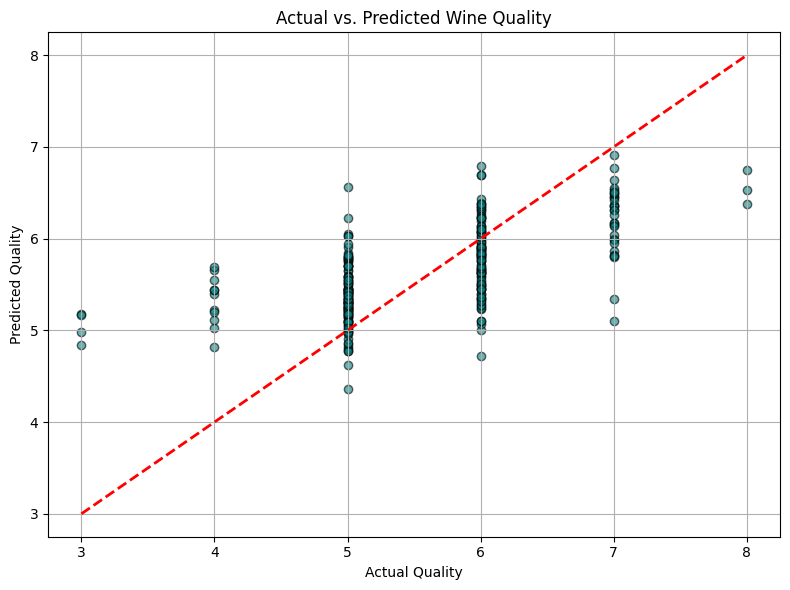

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="teal", edgecolor="k")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs. Predicted Wine Quality")
plt.grid(True)
plt.tight_layout()
plt.show()

## Testing for Assumptions
Next I check whether the assumptions were upheld in this model. 

## Outliers
This assumption has not changed. As written earlier, I use RobustScaling as the mix of us having mixed distributions and a larger need to maintain our outliers necessitates it.

## Linearity
Next, I check to see whether the relationships between the various independent variables (e.g., acidity) holds a roughly linear relationship with wine quality. As seen below, I first use a grid of scatter plots to inspect this. However, it is difficult to here identify this, as the ordinal variable of our dependent variable (wine quality) makes it harder to discern a pattern. Subsequently, I create a grid of boxplots to get a better idea of this, which shows that there is in most cases a *rough* linear shape. After this, I create a residuals plot to further study this. This, however, shows a consistent pattern and a discernible pattern of randomness around the line of zero (in residuals). Also, while the red line - symbolizing the predicted values - is mostly around the zero line (which is good), it deviates in the tails. Thus, this does not support the notion that linearity is upheld.

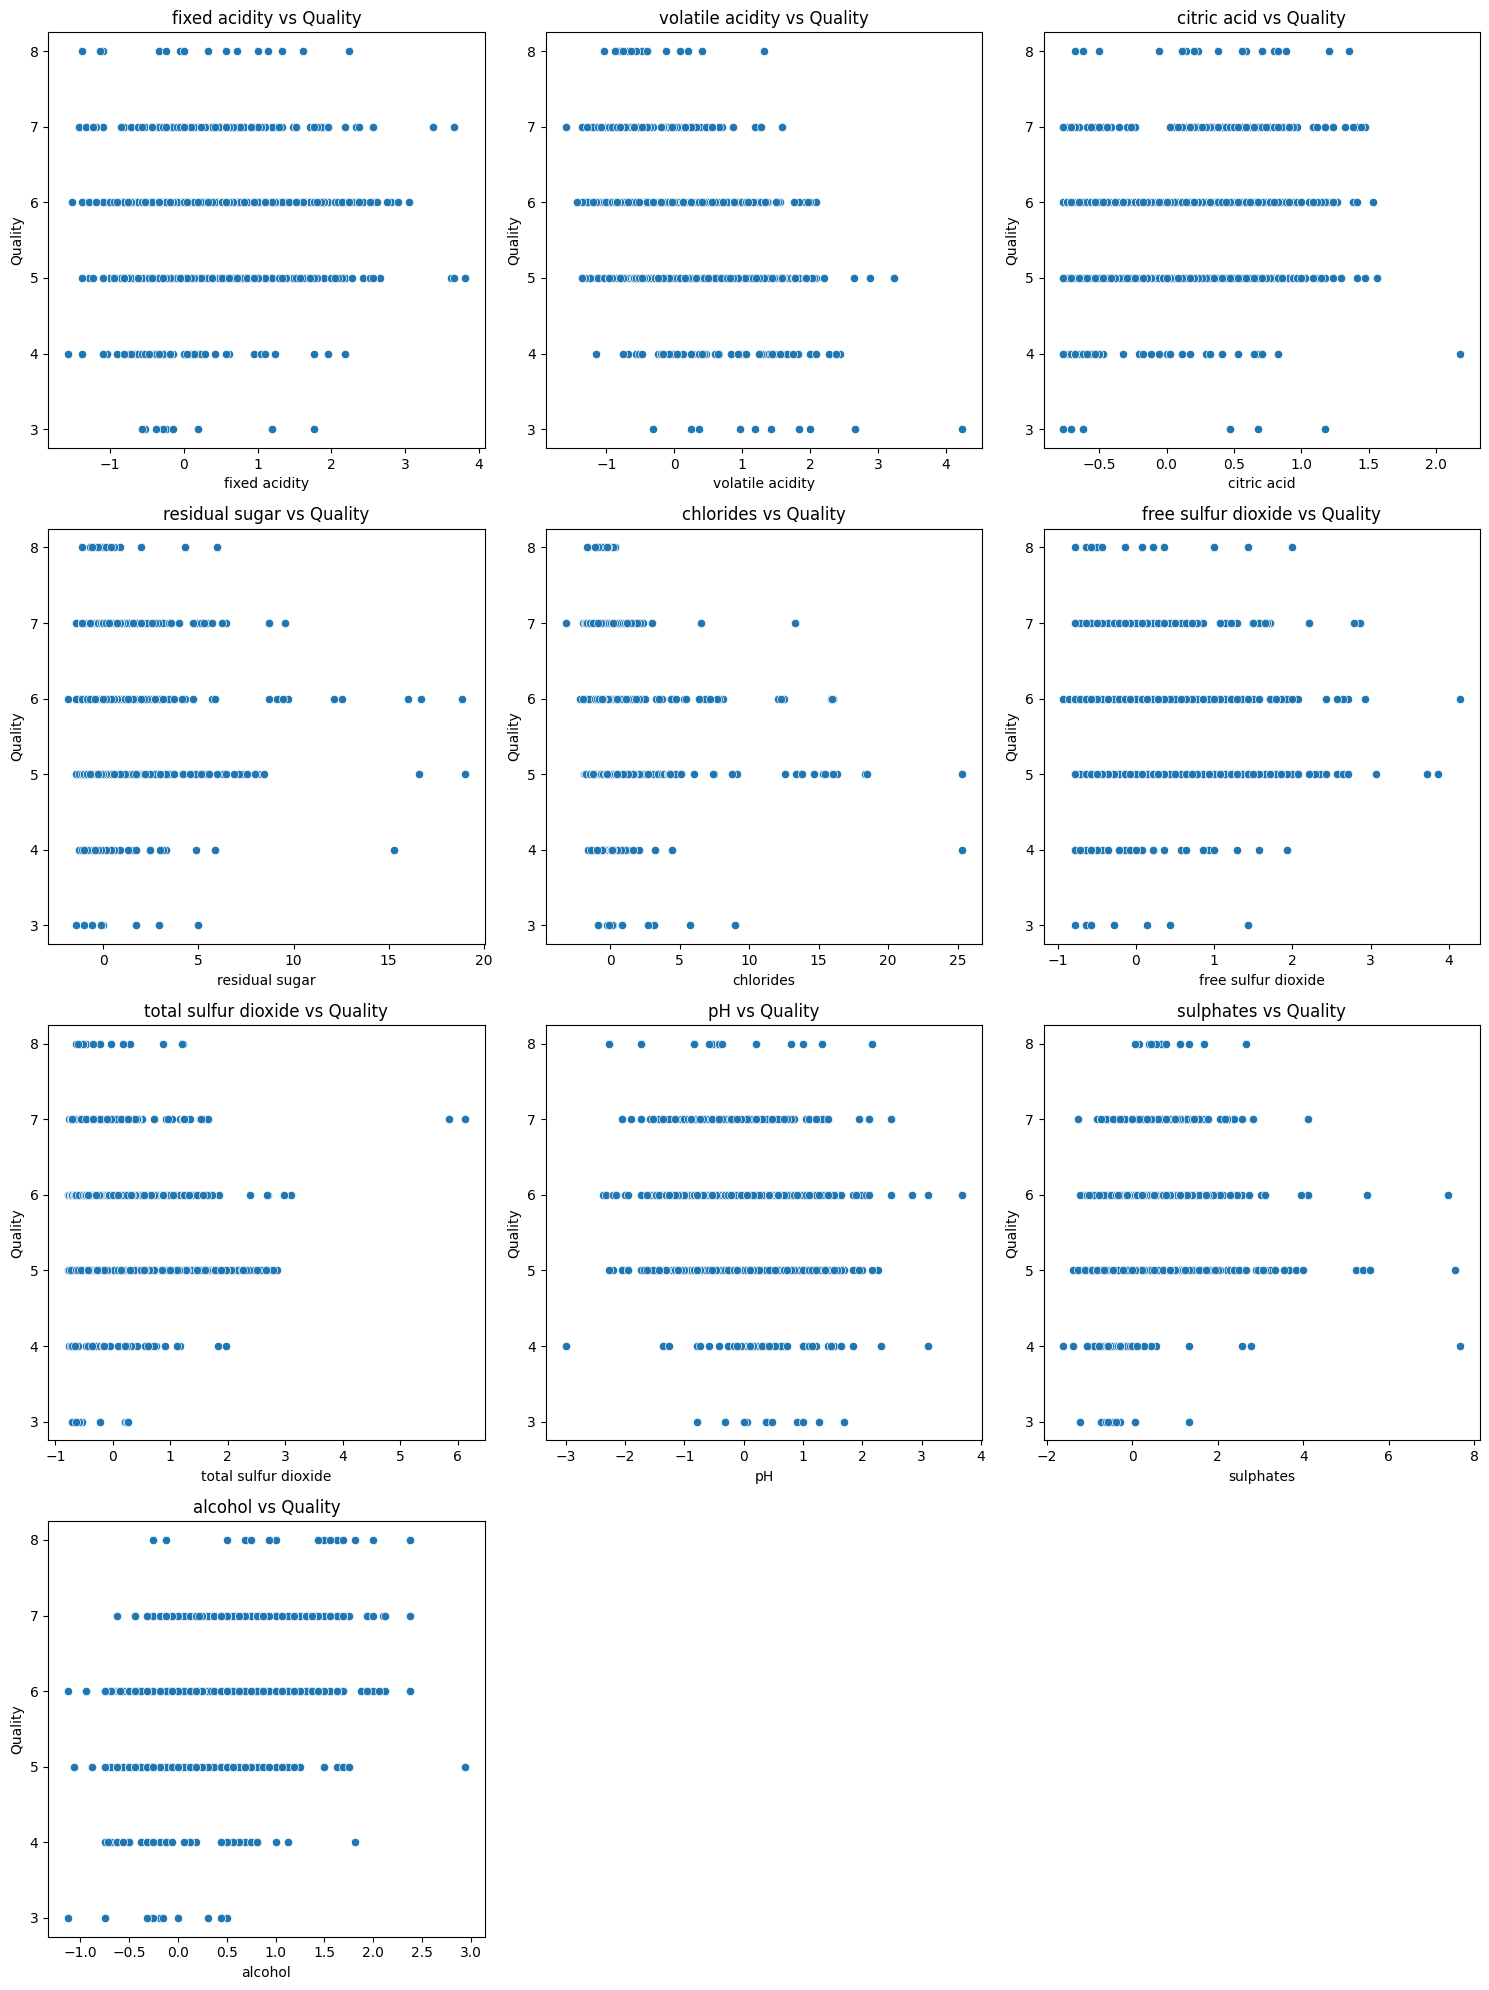

In [21]:
features = df.columns.drop("quality")

n_cols = 3
n_rows = (len(features) // n_cols) + int(len(features) % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

axes = axes.flatten()

for i, col in enumerate(features):
    sns.scatterplot(x=df[col], y=df["quality"], ax=axes[i])
    axes[i].set_title(f"{col} vs Quality")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Quality")

for j in range(len(features), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

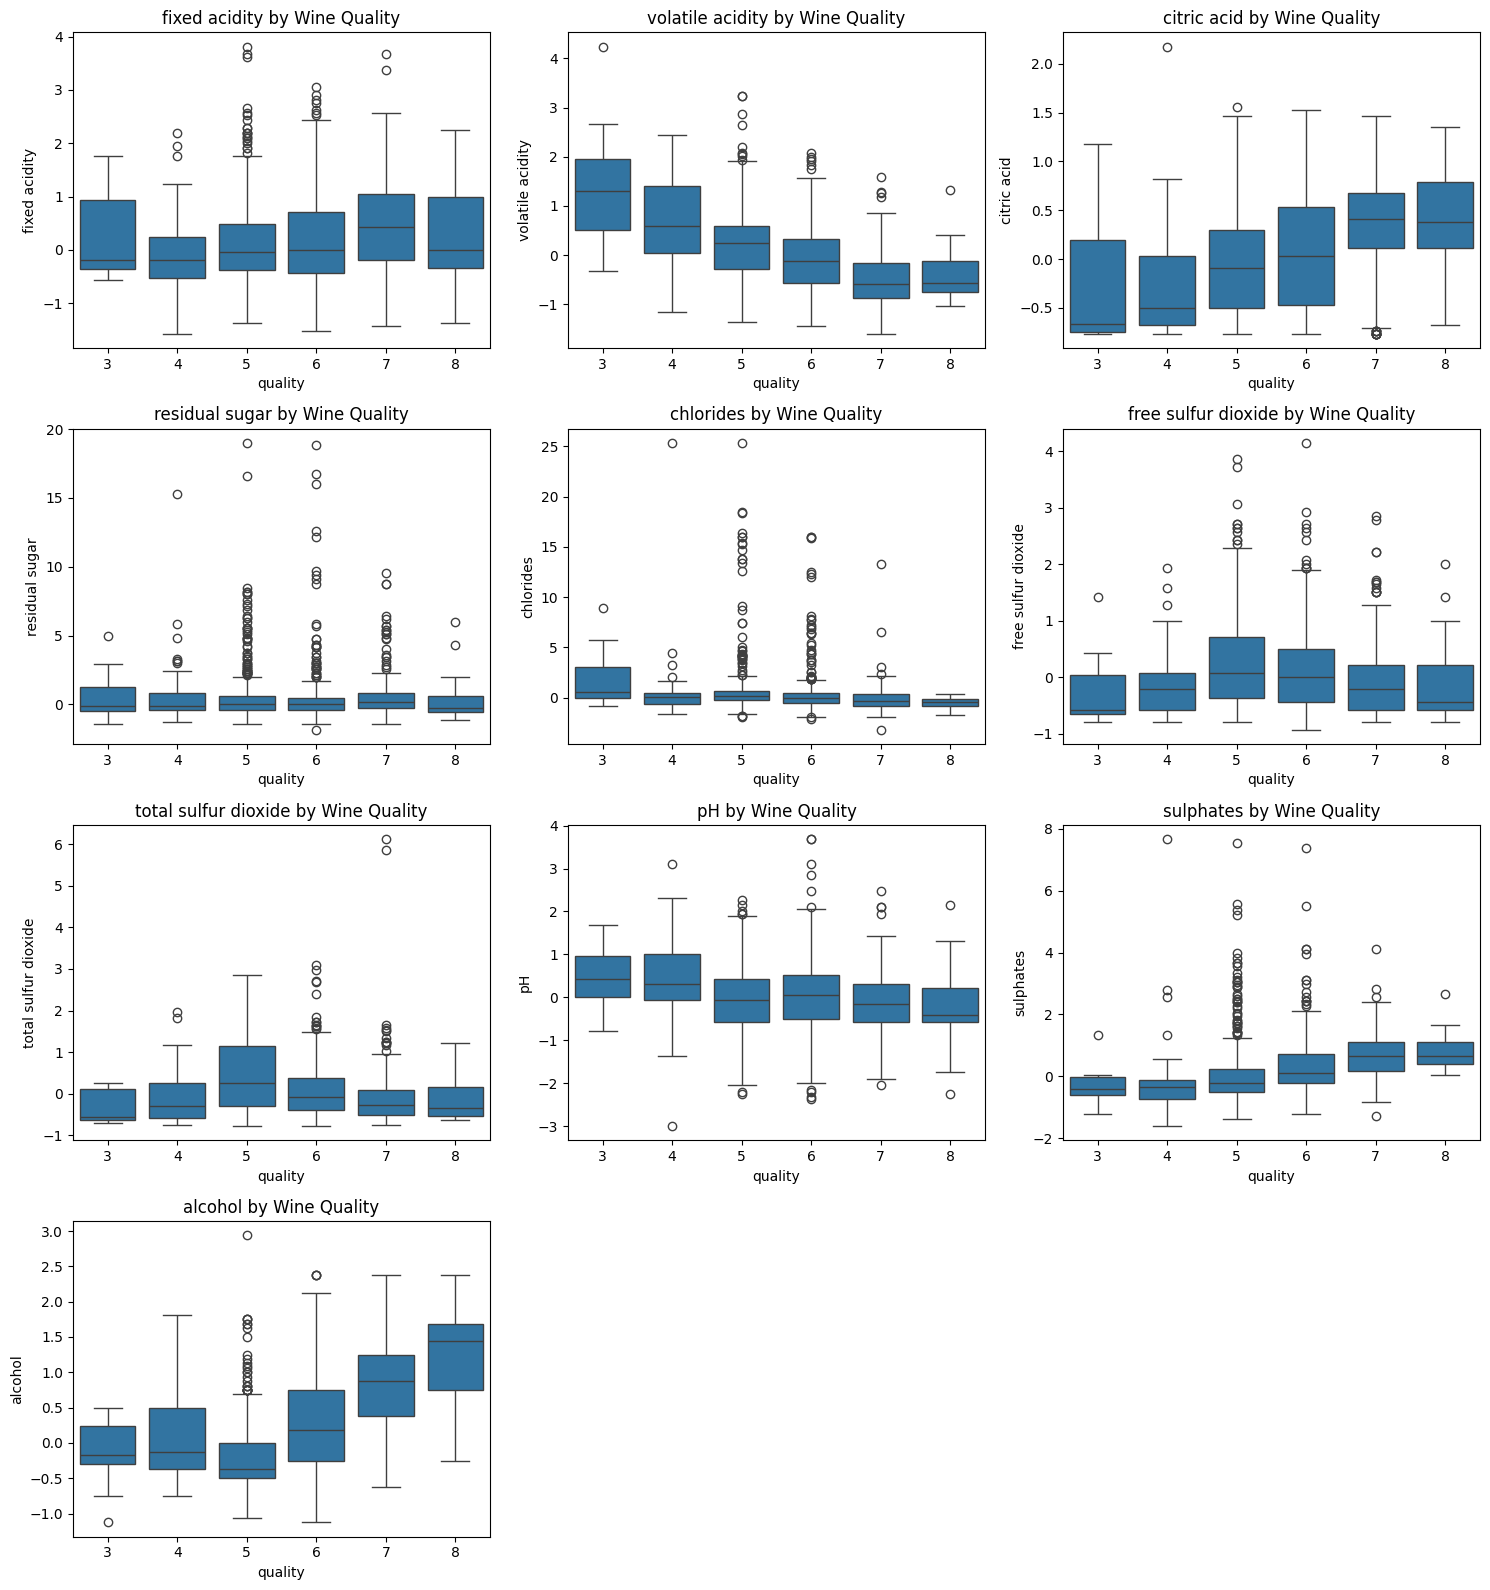

In [22]:
features = df.columns.drop("quality")

n_cols = 3
n_rows = (len(features) // n_cols) + int(len(features) % n_cols != 0)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.boxplot(x="quality", y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} by Wine Quality")

for j in range(len(features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

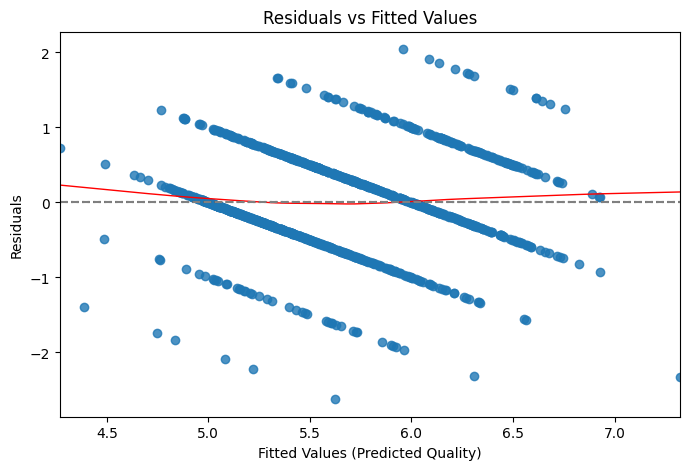

In [23]:
fitted_vals = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(8, 5))
sns.residplot(
    x=fitted_vals, y=residuals, lowess=True, line_kws={"color": "red", "lw": 1}
)
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Fitted Values (Predicted Quality)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

## Non-Correlation of Error Terms
To ensure that the error terms are not related/correlated to each other (i.e., the residuals are independent), we can look at the Durbin-Watson Test displayed earlier in the results. This shows a value of 1.961, which supports the upholding of this assumption. This is as a value much larger or smaller than the number of 2, e.g., 2.5 or 1.5, indicates either a negative or positive correlation, respectively. Thus, this assumption is upheld.

## Constant Variance of Error Terms (Homoscedasticity)
To ensure that the assumption of homoscedasticity is upheld, we can look back at the earlier residuals plot. Here we can see that the distribution of residuals, while not centered around 0 (thus negating the earlier assumption of linearity), is more or less distributed equally across the sides. Thus, this supports the notion that our error terms have a constant variance.
We can further look at whether the error terms are normally distributed, which the Q-Q plot below points towards. Here we can see that while there is some deviation at the tails, the distribution is indeed more or less normally distributed.
After this, we can also ensure that the mean of our residuals is close to or virtually zero. I do this below the Q-Q plot, where we see that this is indeed the case.

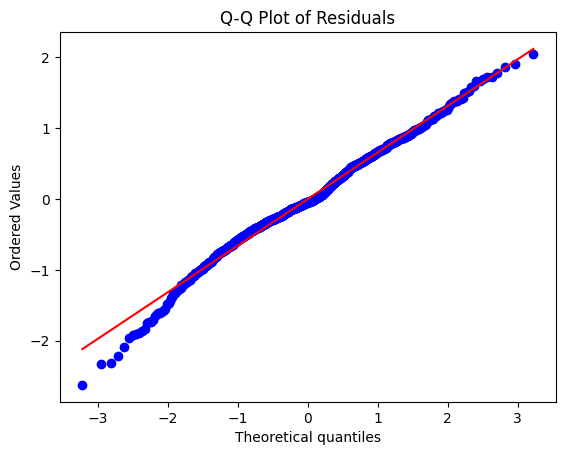

In [24]:
residuals = model.resid

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

In [25]:
residuals = model.resid

mean_residual = residuals.mean()
print("Mean of residuals:", mean_residual)

Mean of residuals: -2.470067491033559e-15


## High-leverage points
Next, we need to ensure that there aren't any particularly high-leverage data points which might be skewing our results. We do this using a Cook's Distance test. However, as we can see, it does indeed seem like there are a variety of data points that cross this limit. Consequently, this harms our model. However, as we, after checking our assumptions, will run a new regression only with the significant variables, this will reduce the size of our sample, which Cook's Distance is dependent on.

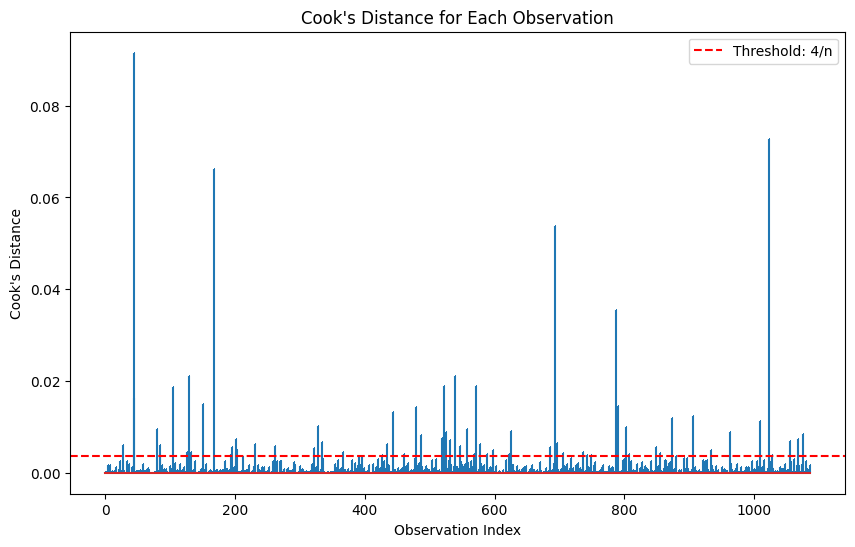

In [26]:
influence = model.get_influence()
(c, p) = influence.cooks_distance

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.axhline(y=4 / len(c), color="r", linestyle="--", label="Threshold: 4/n")
plt.title("Cook's Distance for Each Observation")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

## Multicollinearity
This assumption was upheld earlier, through using VIF to isolate and kick out the appropriate variable.

# Initial Conclusion From the 1st Regression Model
This first regression model indicated that five variables were significant predictors of wine quality. However, several assumptions of the model were violated to differing degrees, such as most importantly the linearity assumption, but also through the existence of high-leverage points.
In the next model, we will check what everything looks like when we limit the model to these three variables. Almost certainly, the R^2 will be different, and it could be that the assumptions also will be different.

# Running the Updated Model

As can be seen below, we still see the five variables to be significant down to a very low alpha (p < 0.001). 

Firstly, the level of volatile acidity is a significant *negative* predictor of wine quality (p < 0.001, β = -0.2733), indicating that as the scaled value of volatile acidity increase by one IQR, wine quality *decreases* by approximately 0.2733, ceteris paribus. 

Secondly, the level of chlorides is a significant *negative* predictor of wine quality (p < 0.001, β = -0.0391), indicating that as the scaled value of chlorides increase by one IQR, wine quality *decreases* by approximately 0.0391, ceteris paribus. 

Thirdly, the level of total sulfur dioxide is a significant *negative* predictor of wine quality (p < 0.001, β = -0.1045), indicating that as the scaled value of total sulfur dioxide increase by one IQR, wine quality *decreases* by approximately 0.1045, ceteris paribus. 

Fourthly, the level of sulphates is a significant *positive* predictor of wine quality (p < 0.001, β = 0.1669), indicating that as the scaled value of total sulfur dioxide increase by one IQR, wine quality *increases* by approximately 0.1669, ceteris paribus. 

Fifthly, the level of alcohol is a significant *positive* predictor of wine quality (p < 0.001, β = 0.4289), indicating that as the scaled value of total sulfur dioxide increase by one IQR, wine quality *increases* by approximately 0.4289, ceteris paribus. 


*This last measure thereby indicates that my hypothesis is incorrect.*

Moreover, the model here indicates that this share of variables accounts for roughly 34.1% of the variance in wine quality (33.8% if using the adjusted R^2), which is quite a high number. Furthermore, this number is quite close to the previous model, which indicates that the presence of all the other variables did not do much in terms of adding predictive value.

When we test this model against the 20% we withheld, we see that we first obtain an RMSE of 0.6478, which means that our model predictions are on average off by 0.6466, which is still a moderate error rate, albeit naturally a little higher than in our old model. Furthermore, we witness an R^2 of 0.4075, which is still noticeably higher than it was for our model itself. This could be pure chance based on how the data was split, or it could indicate that the model performs well across datasets. Through the residuals plot of predicted values versus real values though, we see that the model especially struggles when it comes to predicting in the tails

In [27]:
X = df[["volatile acidity", "chlorides", "total sulfur dioxide", "sulphates", "alcohol"]]
y = df["quality"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_const = sm.add_constant(X_train)

model = sm.OLS(y_train, X_train_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.341
Model:                            OLS   Adj. R-squared:                  0.338
Method:                 Least Squares   F-statistic:                     111.9
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           2.38e-95
Time:                        18:07:56   Log-Likelihood:                -1097.4
No. Observations:                1087   AIC:                             2207.
Df Residuals:                    1081   BIC:                             2237.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    5.5875 

In [28]:
X_test_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_const)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nTest RMSE: {rmse:.4f}")
print(f"Test R-squared: {r2:.4f}")


Test RMSE: 0.6478
Test R-squared: 0.4075


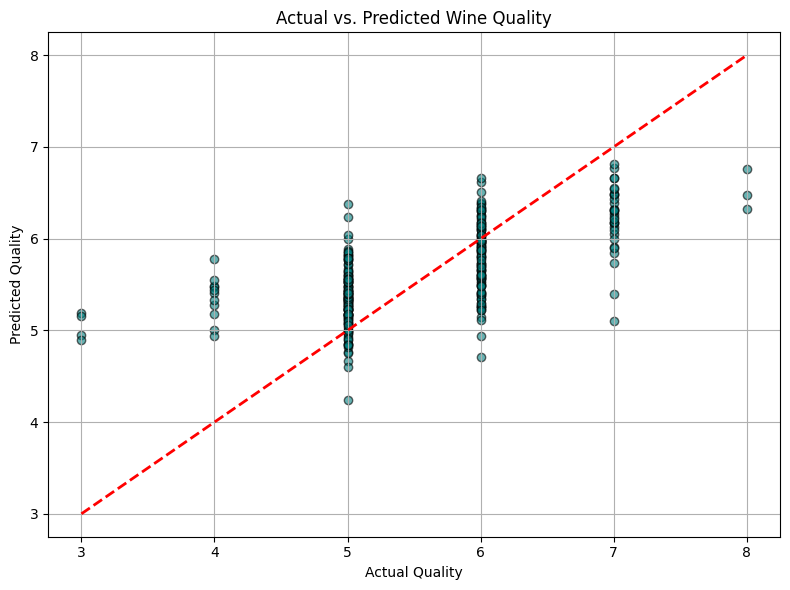

In [29]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="teal", edgecolor="k")
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color="red",
    linestyle="--",
    linewidth=2,
)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Actual vs. Predicted Wine Quality")
plt.grid(True)
plt.tight_layout()
plt.show()

## Testing again for Assumptions

## Outliers
This assumption has not changed. As written earlier, I use RobustScaling as the mix of us having mixed distributions and a larger need to maintain our outliers necessitates it.

## Linearity
Next, I check whether linearity was lived up to. The old scatter plots and boxplots are still the same, but I showcase them here regardless. Both of these indicate graphs with data that behaves in a rough linear shape, so this bodes well. However, when we run the updated residuals plot, this, however, shows a consistent pattern and not an indiscernible pattern of randomness around the line of zero (in residuals). Thus, this does not support the notion that linearity is upheld.

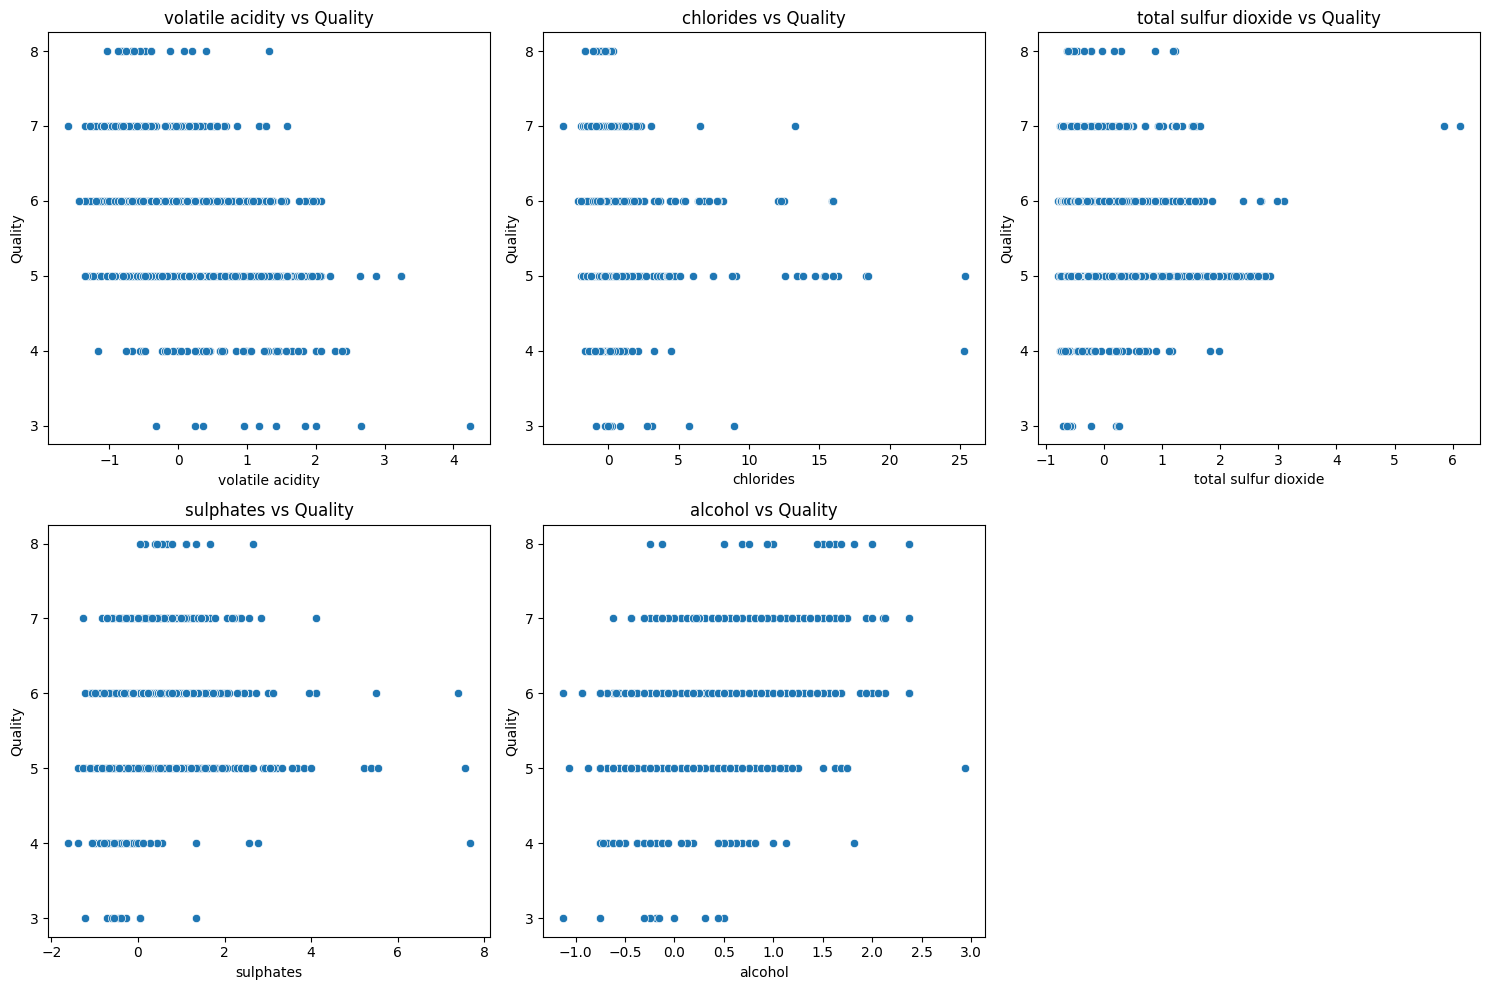

In [30]:
significant_features = ["volatile acidity", "chlorides", "total sulfur dioxide", "sulphates", "alcohol"]

n_cols = 3
n_rows = (len(significant_features) + n_cols - 1) // n_cols  # This calculates the number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))
axes = axes.flatten()

for i, col in enumerate(significant_features):
    sns.scatterplot(x=df[col], y=df["quality"], ax=axes[i])
    axes[i].set_title(f"{col} vs Quality")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Quality")

for j in range(len(significant_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

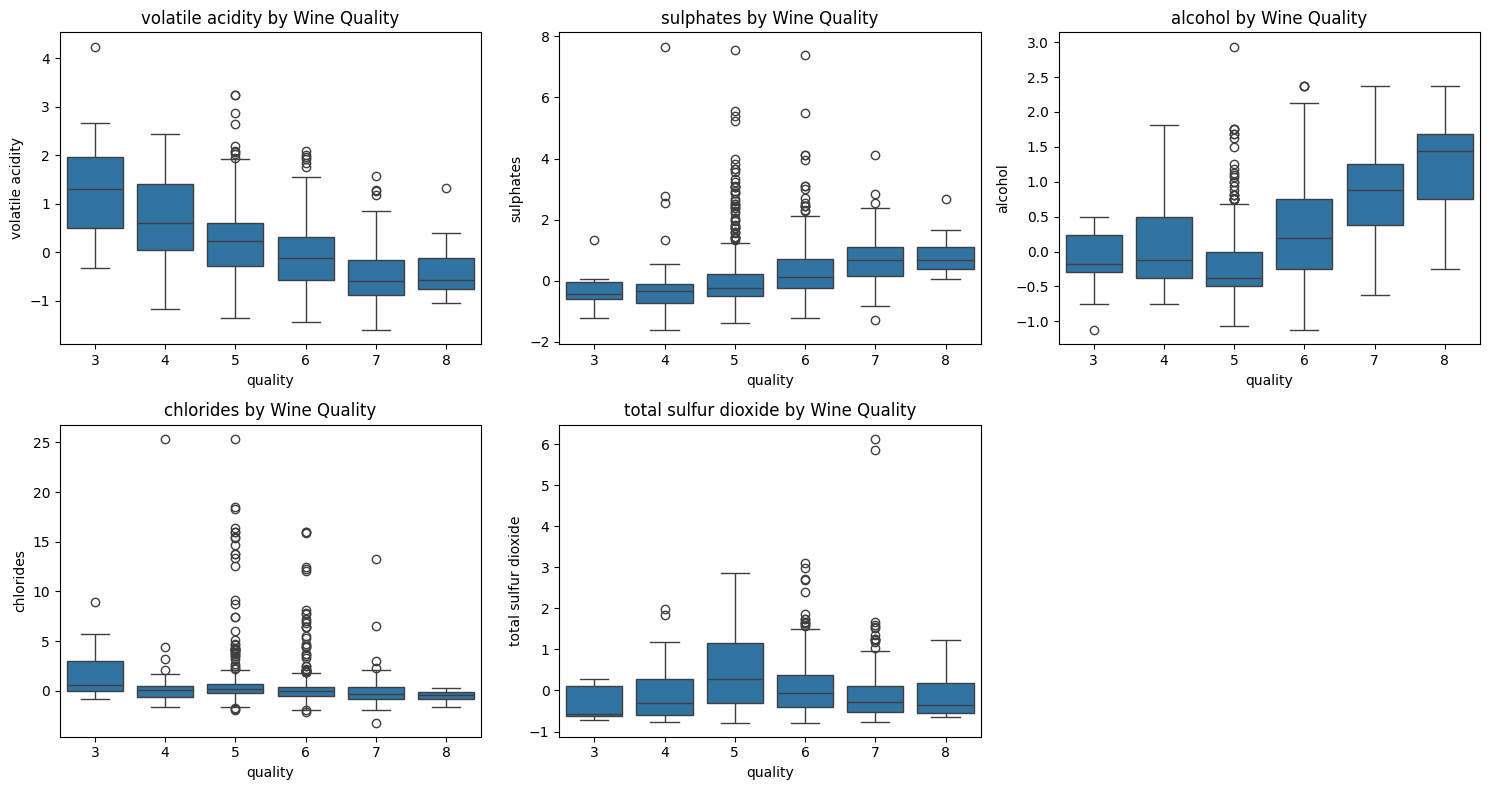

In [31]:
significant_features = ["volatile acidity", "sulphates", "alcohol", "chlorides", "total sulfur dioxide"]

n_cols = 3 
n_rows = (len(significant_features) + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(significant_features):
    sns.boxplot(x="quality", y=col, data=df, ax=axes[i])
    axes[i].set_title(f"{col} by Wine Quality")

for j in range(len(significant_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

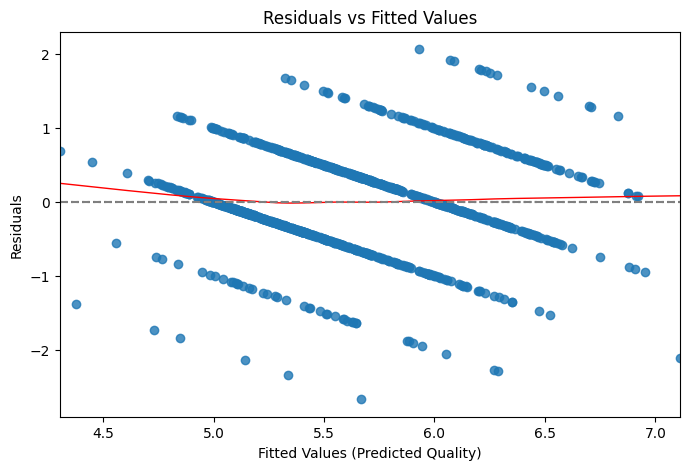

In [32]:
fitted_vals = model.fittedvalues
residuals = model.resid

plt.figure(figsize=(8, 5))
sns.residplot(
    x=fitted_vals, y=residuals, lowess=True, line_kws={"color": "red", "lw": 1}
)
plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Fitted Values (Predicted Quality)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

## Non-Correlation of Error Terms
To ensure that the error terms are not related/correlated to each other (i.e., the residuals are independent), we can look at the Durbin-Watson Test displayed earlier in the results. This shows a value of 1.967, which supports the upholding of this assumption. This is as a value much larger or smaller than the number of 2, e.g., 2.5 or 1.5, indicates either a negative or positive correlation, respectively. Thus, this assumption is upheld.

## Constant Variance of Error Terms (Homoscedasticity)
To ensure that the assumption of homoscedasticity is upheld, we can look back at the earlier residuals plot. Here we can see that the distribution of residuals, while not centered around 0 (thus negating the earlier assumption of linearity), is more or less distributed equally across the sides. Thus, this supports the notion that our error terms have a constant variance.
We can further look at whether the error terms are normally distributed, which the Q-Q plot below points towards. Here we can see that while there is some deviation at the tails, the distribution is indeed more or less normally distributed.
After this, we can also ensure that the mean of our residuals is close to or virtually zero. I do this below the Q-Q plot, where we see that this is indeed the case.

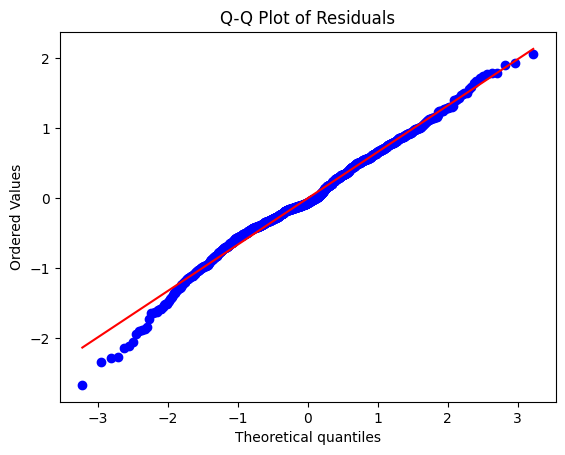

In [33]:
residuals = model.resid

stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

## High-leverage points
Next, we need to ensure that there aren't any particularly high-leverage data points which might be skewing our results. We do this using a Cook's Distance test. However, as we can see, it does indeed seem like there are still a variety of data points that cross this limit. Consequently, this harms our model. Consequently, I will rerun the model without these points.

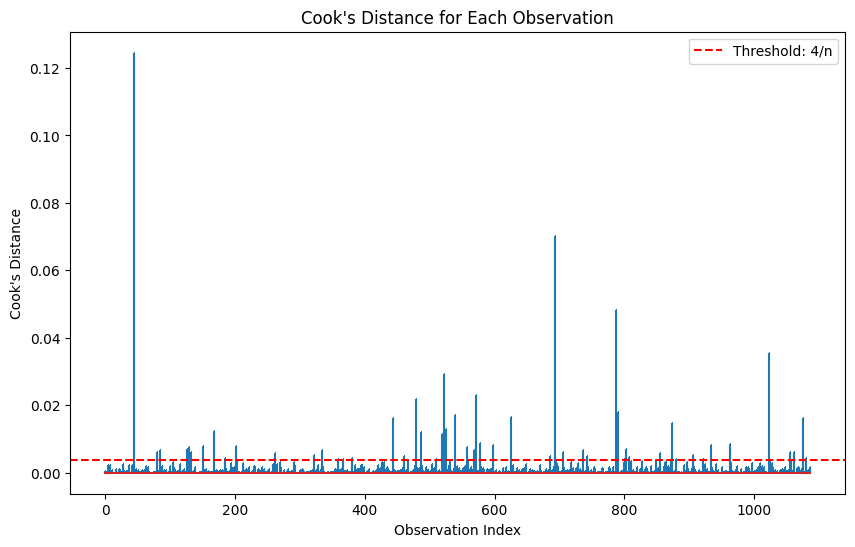

In [34]:
influence = model.get_influence()
(c, p) = influence.cooks_distance

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.axhline(y=4 / len(c), color="r", linestyle="--", label="Threshold: 4/n")
plt.title("Cook's Distance for Each Observation")
plt.xlabel("Observation Index")
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

## Multicollinearity
This assumption was upheld earlier, through using VIF to isolate and kick out the appropriate variable. The same can be seen again below, by just running the VIF on the variables we still maintain in our model

In [35]:
X_sig = df[["volatile acidity", "sulphates", "alcohol", "chlorides", "total sulfur dioxide"]]

X_sig_const = add_constant(X_sig)

vif_data = pd.DataFrame()
vif_data["Variable"] = X_sig_const.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_sig_const.values, i)
    for i in range(X_sig_const.shape[1])
]

print(vif_data)

               Variable       VIF
0                 const  1.227994
1      volatile acidity  1.129530
2             sulphates  1.343710
3               alcohol  1.171905
4             chlorides  1.313138
5  total sulfur dioxide  1.056807


# Conclusion
It seems that, based off of this data, five variables are indicated to be significant predictors of wine quality, namely alcohol content, volatile acidity, and sulphates, total sulfur dioxide, and chlorides.

I ran this model twice, once with all the potential variables, and another time with only the significant predictors to calibrate the results more to the explanatory power of just these variables. While this did yield a higher level of precision for these variables, the model still contains two potential violations of assumptions, which to a degree undermines the validity of the model itself. Firstly, the assumption of linearity, as is often the case, struggles a bit, as the residuals plot shows. However, the scatter plots and boxplots of the data show a slightly different story, with the data here looking more linear. Furthermore, there seems to be a few high-leverage points in the data, as witnessed by the last plot using Cook's distance. This also skews the results to a degree.

I opted to use RobustScaler, as I wanted to diminish the role of outliers while maintaining as large a sample size as possible, given the lacking data, especially on the tails of the dependent variable (wine quality). Standardscaler would be nice for comparing effect sizes, as it would have made things immediately comparable. However, given the situation with these outliers, as well as the important fact that far from all predictor variables followed a Gaussian distribution, I opted not to.

In the future, a different analysis could consider using a non-parametric model such as KNN to showcase this relationship. This would likely get around the issue of linearity not being too present in the dataset. One could also discuss the usage of an ordinal logistic regression instead of a linear regression, as this might arguably fit better to the ordinal scale of our dependent variable. Here, however, I would argue against this, as we have no information indicating that the distance between the scales (e.g., from a 4 to a 5 contra a 6 to a 7) is unequal, which is otherwise when this test would be more warranted.
One could also consider running a logistic regression to predict good versus bad wines. However, this would require a cutoff point, and as the original data set did not have any information about the actual scale of our dependent variable, this seems overly hasty.